In [1]:
import json

import numpy as np
from monty.json import MontyDecoder
from phasemapy.dataio import InstanceData
import matplotlib.pyplot as plt
from scipy.ndimage.filters import generic_filter1d
from scipy.special import wofz
from pymatgen import Element
from scipy.optimize import curve_fit

chemsys = ['Mn', 'Nb', 'V']
photon_e = 13e3
oxide_system = True
# resample_density = 2000
max_shift = 0.015
gaussian_filter = 2

header = '_'.join(sorted(chemsys))
if oxide_system:
    header += '-O'

instance_data = InstanceData.from_file('./data/instance_file_24297_NbMnVO_v02.txt', chemsys, photon_e)
#resample_instance_data = instance_data.resample_xrd(resample_density)

with open(f'./data/{header}_act_short.json')as f:
    act = json.load(f, cls=MontyDecoder)

fitting_results = np.zeros(np.load('output_solution/round3/load200_250.npy').shape)
refine_results = {}

In [3]:
from glob import glob
for filename in glob('output_solution/round3/load*.npy'):
    load = np.load(filename)
    for i in np.where(np.sum(load,axis=(1,2))>0.5)[0]:
        if np.sum(fitting_results[i])==0:
            #print (f"loaded {i}")
            fitting_results[i]=load[i]
print    (np.where(np.sum(fitting_results,axis=(1,2))>0.5)[0]) 
print (np.around(np.sum(fitting_results)))
   

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [4]:
list(zip(np.sum(fitting_results[37],axis=-1),[_.name for _ in act.group_entries]))

[(0.0, 'NbVO5'),
 (0.0, 'VO2'),
 (0.0, 'V2O5'),
 (0.2684017904102802, 'MnNb2O6'),
 (0.0, 'Mn2V2O7'),
 (0.0, 'Mn5VO8'),
 (0.0, 'Mn5VO8'),
 (0.0, 'Mn4Nb2O9'),
 (0.0, 'Mn2V2O7'),
 (0.0, 'Mn3O4'),
 (0.0, 'MnV2O6'),
 (0.7315983176231384, 'Mn2O3'),
 (0.0, 'Mn2V2O7'),
 (0.0, 'Mn3V2O8'),
 (0.0, 'Mn5O8'),
 (0.0, 'NbVO4'),
 (0.0, 'MnO2'),
 (0.0, 'Nb18V4O55'),
 (0.0, 'V8O15')]

In [171]:
class RefineModel:
    def __init__(self,q,sample_xrd,basis_entries,fraction,shift,alpha,gamma,wavelength):
        self.q = q
        self.sample_xrd = sample_xrd/np.sum(sample_xrd)*6000
        self.basis_entries = basis_entries
        self.fraction=fraction
        self.shift=shift
        self.alpha=alpha
        self.gamma=gamma
        self.wavelength=wavelength
        
    
    @property
    def params(self):
        params = []
        for ge,frac, shift,alpha,gamma in zip(self.basis_entries,self.fraction, self.shift,self.alpha,self.gamma):
            e = ge.entries[0]
            locs,amps = e.data['xrd']
            y=self.get_voigt_xrd(self.q,locs*shift,amps,alpha,gamma,self.wavelength)
            amps /= (np.sum(y)/6000)
            info = {'qlocs':locs,'amps':amps,'frac':frac,'shift':shift,'alpha':alpha,'gamma':gamma}
            params.append(info)
        return params
    
    @property
    def current_model(self):
        ys = []
        for param in self.params:
            locs = param['qlocs']
            amps = param['amps']
            frac = np.abs(param['frac'])
            shift = param['shift']
            alpha = param['alpha']
            gamma = param['gamma']
            y=self.get_voigt_xrd(self.q,locs*shift,amps*frac,alpha,gamma,self.wavelength)
            ys.append(y)
        ys = np.array(ys)    
        return ys    
            
    
    @staticmethod    
    def Voigt(x, c, alpha,gamma,amps):
        x = x[:,None]
        c = c[None,:]
        amps = np.abs(amps[None,:])
        #alphagamma=alphagamma[None,:]
        """ Return the c-centered Voigt line shape at x, scaled to match HWHM of Gaussian and Lorentzian profiles."""

        alpha = 0.61065 * alpha[None,:]
        gamma = 0.61065 * gamma[None,:]
        sigma = alpha / np.sqrt(2 * np.log(2))
        profile = np.real(wofz(((x - c) + 1j * gamma) / (sigma * np.sqrt(2)))) / (sigma * np.sqrt(2 * np.pi))
        profile *= amps
        profile = np.sum(profile,axis=1)
        return profile
    
    
    @property
    def recon(self):
        recon = np.sum(self.current_model,axis=0)
        return recon
    
    @property
    def current_loss(self):
        recon = self.recon
        #return np.sum((recon-self.sample_xrd)**2)
        return np.sqrt(np.sum((recon-self.sample_xrd)**2)/np.sum(self.sample_xrd**2))
    
    @staticmethod
    def get_voigt_xrd(q_vectors,q_loc,intensity,alpha,gamma,wavelength):
        intensity = np.abs(intensity)
        widen = 1/np.cos(np.arcsin(np.array(q_loc)/np.pi/2/10*wavelength/2))
        alpha = alpha*widen
        gamma = alpha*widen       
        data = RefineModel.Voigt(q_vectors,q_loc,alpha,gamma,intensity)#*intensity.reshape(1,-1)
        return data
    
    
    def refine_param(self,target):
        y_data = self.sample_xrd-np.sum(self.current_model,axis=0)
        y_data += self.current_model[target]
        x_data = self.q
        

        param = self.params[target]
        shift = param['shift']
        frac = param['frac']
        alpha = param['alpha']
        gamma = param['gamma']
        

        def fit_function(x_data,alpha,gamma,shift,frac): #,shift,sigma
            return RefineModel.get_voigt_xrd(x_data,param['qlocs']*shift,param['amps']*np.abs(frac),alpha,gamma,self.wavelength)
            
        fitresult,_ = curve_fit(fit_function,x_data,y_data,p0=[param['alpha'],param['gamma'],param['shift'],param['frac']])#param['shift'],param['sigma']
        self.alpha[target]=fitresult[0]
        self.gamma[target]=fitresult[1]
        self.shift[target]=fitresult[2]
        self.fraction[target]=fitresult[3]
        
        return y_data
    
    


    
    

    

# params = refine_model.params




# ys = refine_model.current_model
# plt.plot(refine_model.q,refine_model.sample_xrd,label='exp')
# print (refine_model.current_loss)
# refine_model.refine_param(1)
# refine_model.refine_param(0)
# plt.plot(refine_model.q,np.sum(refine_model.current_model,axis=0),label='new',alpha=.6) 
# print (refine_model.current_loss)

# plt.legend()



    

   

In [174]:
q = instance_data.q
del refine_results[314]

In [175]:
for sample_index in [314]:
    if sample_index in refine_results.keys():
        continue
    print (f'Refining sample {sample_index}')    
    sample_xrd = instance_data.sample_xrd[sample_index]
    phase_indexes = np.where(act.amount_matrix[sample_index]>0)[0]    
    phase_fraction = act.amount_matrix[sample_index][phase_indexes]
    
    phase_indexes = phase_indexes[np.argsort(-phase_fraction)]
    phase_fraction = phase_fraction[np.argsort(-phase_fraction)]

    basis_entries = [act.group_entries[i] for i in phase_indexes]

    shift = act.shift_matrix[sample_index][phase_indexes]
    alpha = np.array([0.096 for i in shift])
    gamma = np.array([0.096 for i in shift])
    
    refine_model = RefineModel(q,sample_xrd,basis_entries,phase_fraction,
                               shift,alpha,gamma,instance_data.wavelength)

    print (refine_model.current_loss)
    for i in range(len(phase_indexes)):
        refine_model.refine_param(i)
    params=refine_model.params
    print (refine_model.current_loss)
    #print (params)
    
    refine_results[sample_index]={"phase_indexes":phase_indexes,"fractions":[param['frac'] for param in params],"shifts":[param['shift'] for param in params],'alphas':[param['alpha'] for param in params],'gammas':[param['gamma'] for param in params]}
    print (refine_results[sample_index])
    
    

Refining sample 314
0.8661709565808077


/Users/yizhou/miniconda3/envs/py3k/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.44940432084767357
{'phase_indexes': array([10, 12,  0,  1]), 'fractions': [0.5864988468202013, 0.2012073475124667, 0.17355608921678245, -0.1026622858734388], 'shifts': [0.9974126005884617, 1.0215299087870868, 0.9968735113923964, 1.0152694067992278], 'alphas': [0.06354272151256711, 0.07183596171843641, 0.05317035031137604, 0.02960347472042876], 'gammas': [0.096, 0.096, 0.096, 0.096]}


In [176]:
print (len(refine_results.keys()))
import copy
keep_record = copy.deepcopy(refine_results)

317


In [177]:
keep_record.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [178]:
with open ('/Users/yizhou/Pycharmprojects/phasemapy/data/data_Si/K8soltn/Nb-Mn-VO_output_Ori_Rec.txt') as f:
    lines = f.readlines()
orig_xrd_2016 = []
recon_xrd_2016 = []

for l in lines[3:317+3]:
    orig_xrd_2016.append(list(map(float,l.split('=')[1].split(','))))
orig_xrd_2016 = np.array(orig_xrd_2016) 
for l in lines[317+3:317*2+3]:
    recon_xrd_2016.append(list(map(float,l.split('=')[1].split(','))))
recon_xrd_2016 = np.array(recon_xrd_2016)  

q_2016 = list(map(float,lines[2].split('=')[1].split(',')))

recon_xrd_2016=recon_xrd_2016/np.sum(orig_xrd_2016,axis=1,keepdims=True)*6000
orig_xrd_2016=orig_xrd_2016/np.sum(orig_xrd_2016,axis=1,keepdims=True)*6000


In [179]:
model_2016_loss = np.sqrt(np.sum((recon_xrd_2016-orig_xrd_2016)**2,axis=1)/np.sum(orig_xrd_2016**2,axis=1))

In [182]:
recons,origs = [],[]
for sample_index in range(317):
    #print (refine_results[sample_index])
#     if sample_index not in refine_results.keys():
#         continue
    param = refine_results[sample_index]
    sample_xrd = instance_data.sample_xrd[sample_index]
    basis_entries = [act.group_entries[i] for i in param['phase_indexes']]
    phase_fraction = param['fractions']
    shift = param['shifts']
    alpha = param['alphas']
    gamma = param['gammas']
    refine_model = RefineModel(q,sample_xrd,basis_entries,phase_fraction,
                               shift,alpha,gamma,instance_data.wavelength)
    print (f'{sample_index:03} {refine_model.current_loss:.6f}')
    
    recons.append(refine_model.recon)
    origs.append(refine_model.sample_xrd)
    
    plt.plot(q,refine_model.sample_xrd,label='orig.')
    plt.plot(q,refine_model.recon,alpha=0.5,label='recon.our model')
    plt.plot(q,refine_model.recon-refine_model.sample_xrd-20,label='diff. our model')
    plt.plot(q_2016,recon_xrd_2016[sample_index],alpha=0.5,label='recon 2016')
    

    plt.plot(q_2016,recon_xrd_2016[sample_index]-orig_xrd_2016[sample_index]-40,label='diff 2016')
    plt.legend(title=f'Sample {sample_index}')
    plt.savefig(f'recon_figures/recon_{sample_index:03}.pdf',format='pdf',transparent=True,bbox_inches='tight')
    plt.close()
    

000 0.151775
001 0.167404
002 0.150384
003 0.119580
004 0.140956
005 0.154105
006 0.156670
007 0.202118
008 0.240831
009 0.237219
010 0.192292
011 0.179945
012 0.184215
013 0.160743
014 0.124334
015 0.137950
016 0.152158
017 0.157210
018 0.193761
019 0.220864
020 0.236010
021 0.247526
022 0.242533
023 0.190431
024 0.194739
025 0.157139
026 0.157282
027 0.160135
028 0.140426
029 0.131963
030 0.160583
031 0.172996
032 0.194498
033 0.214209
034 0.240139
035 0.229589
036 0.233846
037 0.232840
038 0.185442
039 0.183848
040 0.189375
041 0.141242
042 0.155156
043 0.135606
044 0.147946
045 0.146431
046 0.166999
047 0.179397
048 0.188312
049 0.221744
050 0.250167
051 0.248662
052 0.221573
053 0.224045
054 0.210711
055 0.180967
056 0.179077
057 0.186962
058 0.135403
059 0.141718
060 0.153631
061 0.136909
062 0.128748
063 0.161309
064 0.201769
065 0.204047
066 0.243423
067 0.264242
068 0.265873
069 0.271754
070 0.224563
071 0.220803
072 0.181231
073 0.178245
074 0.181998
075 0.192345
076 0.142260

In [183]:
recons = np.array(recons)
origs = np.array(origs)
model_our_loss = np.sqrt(np.sum((recons-origs)**2,axis=-1)/np.sum(origs**2,axis=1))



0.2715105268059571 0.2544294073926528
[221 242 220 222 261]
[214 215 194 234 166]
[251 211 252 250 302]


Text(0.5, 0, 'Model (current) XRD loss')

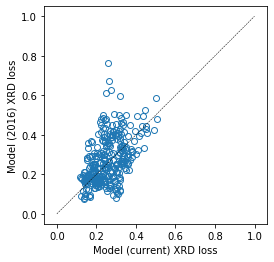

In [196]:
plt.figure(figsize=(4,4))
plt.plot(model_our_loss,model_2016_loss,'o',mfc='None')
plt.axis('equal')

plt.plot([0,1],[0,1],'k--',lw=0.5)
plt.xlim(0,1)

print (np.average(model_2016_loss),np.average(model_our_loss))

print (np.argsort(model_2016_loss-model_our_loss)[:5]) #out worst
print (np.argsort(-model_2016_loss+model_our_loss)[:5]) # 2016 worst

print (np.argsort(-model_2016_loss*model_our_loss)[:5]) # both worst

plt.ylabel('Model (2016) XRD loss')
plt.xlabel('Model (current) XRD loss')


In [151]:
np.argsort(-model_our_loss+model_2016_loss)

array([314, 221, 242, 220, 222, 261, 201, 241, 219, 199, 243, 244, 240,
       259, 218, 181, 180, 200, 304, 260, 239, 303, 202, 223, 271, 198,
       179, 182, 160, 233, 278, 258, 288, 287, 262, 224, 284, 203, 268,
       178, 285, 277, 280, 183, 286, 265, 134, 263, 157, 226, 196, 173,
       172, 153, 161,  95, 279, 225, 155, 227, 228, 190, 238, 139, 283,
       159, 302, 269, 266, 305, 270, 290, 267, 176,  58, 171, 264, 204,
       158, 289, 213, 115, 217, 152, 291, 207, 114, 184, 175,  41, 138,
       151, 154, 312, 205, 273, 162, 191, 313, 129,  76, 229, 137, 210,
       133, 110, 192, 188,  25, 149, 193, 150, 170, 211,  96, 254, 272,
       142, 209, 177,  10, 135, 148, 315, 169, 231, 300, 212, 245, 163,
       230, 119,  77,  11, 164, 311, 276, 197, 306, 208, 206, 189, 132,
       131, 100, 185, 316, 237, 156, 136, 246, 120, 130, 141,  91, 111,
       113, 143,  92, 112, 257,  59, 118, 117,  98, 281, 122, 301, 282,
       247,  99,  44, 116, 123,  97, 187,  93, 299, 310,  78,  7

In [152]:
model_our_loss[314],model_2016_loss[314]

(0.757270884678302, 0.44700706709538846)

In [198]:
new_amount_matrix=np.zeros(act.amount_matrix.shape)
print (new_amount_matrix.shape)
for sample_index in refine_results:
    new_amount_matrix[sample_index][refine_results[sample_index]['phase_indexes']]=refine_results[sample_index]['fractions']
np.sum(new_amount_matrix)    

(317, 19)


308.3849926101654

In [200]:
new_amount_matrix/=np.sum(new_amount_matrix,axis=1,keepdims=True)
np.sum(new_amount_matrix) 

317.0

In [201]:
np.save('refine_amt_matrix.npy',new_amount_matrix)

In [202]:
!scp refine_amt_matrix.npy macmini:~

refine_amt_matrix.npy                         100%   47KB   3.1MB/s   00:00    


In [52]:
curve_fit(f, xdata, ydata)

TypeError: <_io.TextIOWrapper name='./data/Mn_Nb_V-O_act_short.json' mode='r' encoding='UTF-8'> is not a callable object

In [21]:
dir(resample_instance_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'chemsys',
 'comp_dict',
 'dim',
 'from_file',
 'photon_e',
 'q',
 'qmax',
 'qmin',
 'resample_xrd',
 'sample_comp',
 'sample_num',
 'sample_xrd',
 'twotheta',
 'wavelength']

In [24]:
resample_instance_data.q[1]/resample_instance_data.q[0]

1.0016573758684602